In [1]:
function mean(p::Dict)
    m = zero(typeof([k for k in values(p)][1]))
    for k in keys(p)
        m += k * p[k]
    end
    return m
end

function stddev(p::Dict)
    m = mean(p)
    s = zero(typeof([k for k in values(p)][1]))
    for k in keys(p)
        s += p[k]*(k-m)^2
    end
    return sqrt(s)
end

function convolve(p::Dict,q::Dict)
    pk = keys(p)
    qk = keys(q)
    s = union(vcat([a + b for a in pk, b in qk]...))
    d = Dict(zip(s,zeros([typeof(k) for k in values(p)][1],length(s))))
    for i in pk
        for j in qk
            d[i+j] += p[i]*q[j]
        end
    end
    return d
end

function convolve(p::Dict,n::Integer)
    if n == 1
        return p
    else
        return convolve(p,convolve(p,n-1))
    end
end

convolve (generic function with 2 methods)

In [2]:
Pkg.add("Gadfly")
using Gadfly

import Gadfly.plot
import Gadfly.layer

function plot(d::Dict;kwargs...)
    s = sort([(a,b) for (a,b) in zip(keys(d), values(d))])
    return Gadfly.plot(x=[k[1] for k in s],y=[k[2] for k in s],Geom.line)
end

function plot(d::Dict,μ::Real,σ::Real;kwargs...)
    s = sort([(a,b) for (a,b) in zip(keys(d), values(d))])
    return Gadfly.layer(x=[(k[1]-μ)/σ for k in s],y=[k[2]*σ for k in s],Geom.line)
end

function layer(d::Dict;kwargs...)
    s = sort([(a,b) for (a,b) in collect(d)])
    return Gadfly.layer(x=[k[1] for k in s],y=[k[2]*σ for k in s],Geom.line)
end

function layer(d::Dict,μ::Real,σ::Real;kwargs...)
    s = sort([(a,b) for (a,b) in collect(d)])
    return Gadfly.layer(x=[(k[1]-μ)/σ for k in s],y=[k[2]*σ for k in s],Geom.line)
end

function gaussian(μ::Real,σ::Real,k::Real=1) 
    x = linspace(μ - 3*σ , μ + 3*σ , 100)
    y = k/sqrt(2*π*σ^2)*exp(-(x-μ).^2/(2*σ^2))
    return Gadfly.layer(x=x,y=y,Geom.line,Theme(default_color=colorant"red"))
end

function compare(p::Dict,m::Integer,n::Integer)
    μ, σ = mean(p), stddev(p) # caculate mean and standard deviation and assign them to μ and σ
    p[maximum(keys(p))] += 1 - sum(values(p)) # Adds any leftover probability to the largest outcome
    
    r = m:n # r = m:n plots the densities from the a-fold convolution to the b-fold convolution
    plot([gaussian(0,1);
    [layer(Dict(filter(tuple -> last(tuple) > 1e-4, collect(convolve(p,n)))),μ*n,σ*sqrt(n)) 
        for n in r]]...)
end

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Gadfly
INFO: Use `Pkg.update()` to get the latest versions of your packages


compare (generic function with 1 method)

In [3]:
p = Dict([k => 1/6 for k in 1:6]) # A fair die roll

Dict{Int64,Float64} with 6 entries:
  4 => 0.16666666666666666
  2 => 0.16666666666666666
  3 => 0.16666666666666666
  5 => 0.16666666666666666
  6 => 0.16666666666666666
  1 => 0.16666666666666666

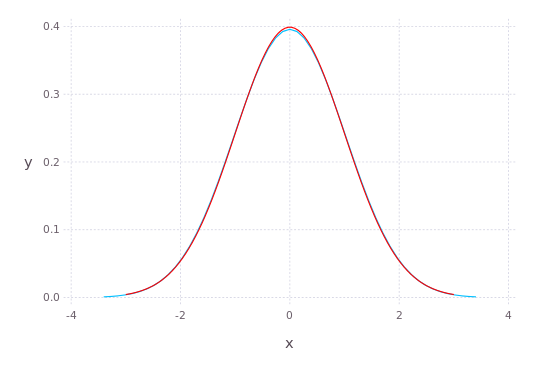

In [4]:
compare(p,20,20)

In [5]:
q = Dict([k => exp(-5.0)*5.0^k/factorial(float(k)) for k in 0:20]) # Poisson, cut of at 20

Dict{Int64,Float64} with 21 entries:
  18 => 4.014640377886977e-6
  2  => 0.08422433748856833
  16 => 4.91391982253366e-5
  11 => 0.00824217668537358
  0  => 0.006737946999085467
  7  => 0.104444862957054
  9  => 0.03626557741564375
  10 => 0.01813278870782187
  19 => 1.0564843099702573e-6
  17 => 1.4452705360393119e-5
  8  => 0.06527803934815875
  6  => 0.1462228081398756
  4  => 0.1754673697678507
  3  => 0.14037389581428056
  5  => 0.1754673697678507
  20 => 2.6412107749256427e-7
  13 => 0.0013208616482970478
  14 => 0.00047173630296323143
  15 => 0.00015724543432107713
  12 => 0.0034342402855723248
  1  => 0.03368973499542734

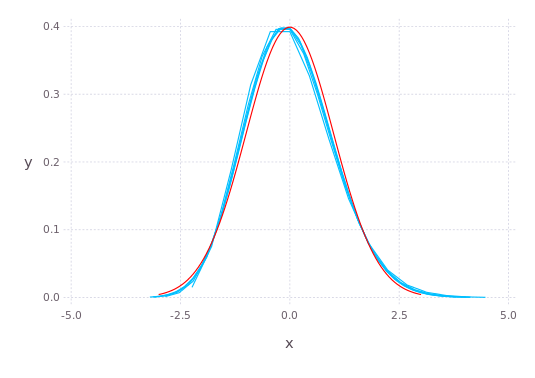

In [6]:
compare(q,1,5)

In [7]:
r = Dict([k => 2.0^(-k) for k in 1:20]) # Geometric, cut off at 20

Dict{Int64,Float64} with 20 entries:
  18 => 3.814697265625e-6
  2  => 0.25
  16 => 1.52587890625e-5
  11 => 0.00048828125
  7  => 0.0078125
  9  => 0.001953125
  10 => 0.0009765625
  19 => 1.9073486328125e-6
  17 => 7.62939453125e-6
  8  => 0.00390625
  6  => 0.015625
  4  => 0.0625
  3  => 0.125
  5  => 0.03125
  20 => 9.5367431640625e-7
  13 => 0.0001220703125
  14 => 6.103515625e-5
  15 => 3.0517578125e-5
  12 => 0.000244140625
  1  => 0.5

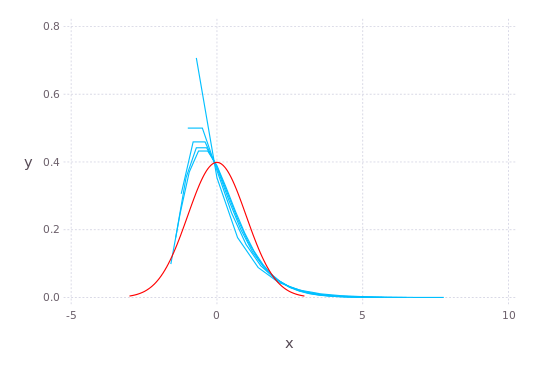

In [8]:
compare(r,1,5)